# Step 1: Get data

In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

Just to make sure configurations will work for either versions

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Step 2: Sample training set and testing set

In [3]:
# PHASE 1: TEST SET GENERATION
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


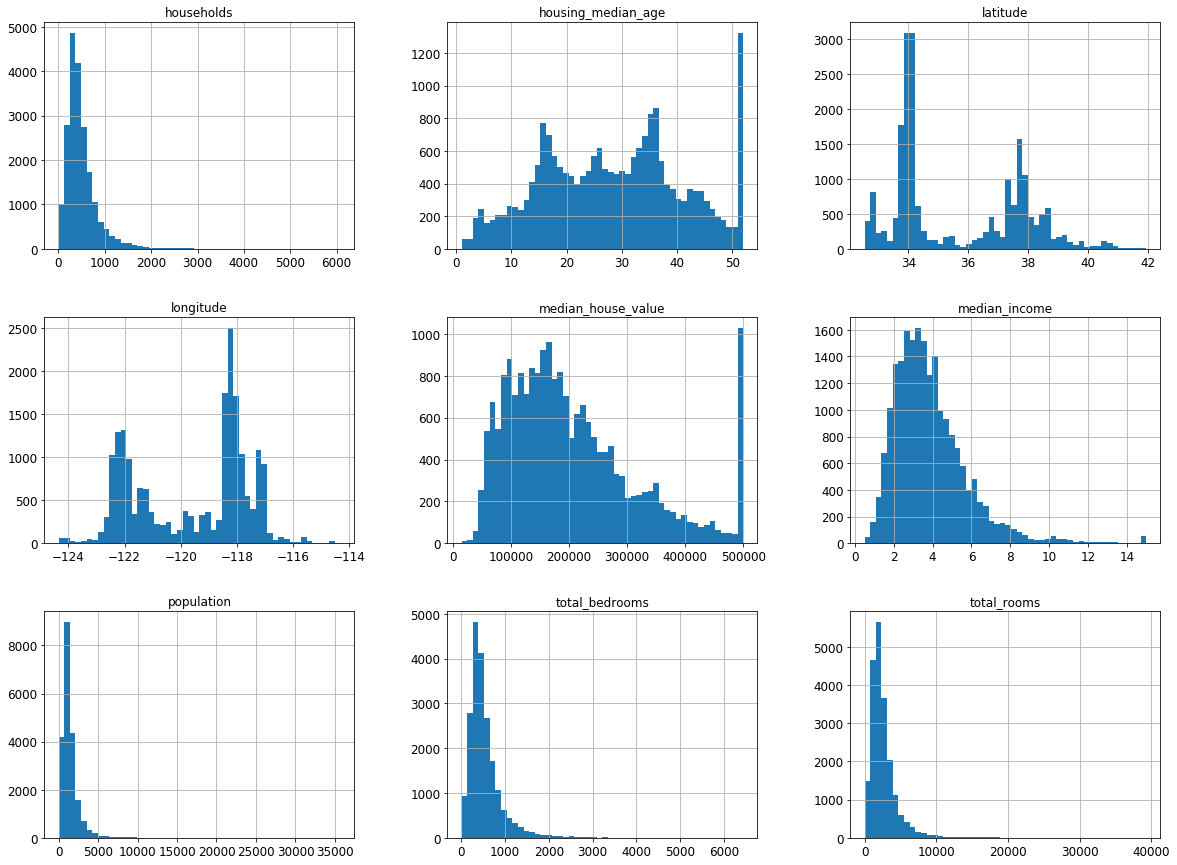

In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [9]:
# creating test set

import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) *test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [10]:

# use splitter

train_set, test_set = split_train_test(housing, 0.2)
print (len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


In [11]:
import hashlib

# computes a hash of each instance's identifier and keep last byte of hash, 
# and put instance in the test set if =< 51 / ~20% of 256

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 265 * test_ratio

# revised version of splitter
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio,hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# add identifier for test_set_check
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [12]:
# ^ is the same as scikit's

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:


# looking at median income to put it in bins
# note that it is right tail heavy so we use to divide it by 1.5 to get 5.5 bins

# create income category attribute. divide median income by 1.5 and round up using ceil
housing["income_cat"] = np.ceil(housing["median_income"]/1.5)
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [14]:
# remain if condition / first parameter met, if not, change to 5
# output = 6 in index 0 becomes 5, all rows have income cat of max 5
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


In [15]:
# now ready for stratified sampling, use Scikit-Learn's StratifiedShuffleSplit class
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    


In [16]:
housing['income_cat'].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
housing['income_cat'].unique()

array([5., 4., 3., 2., 1.])

In [18]:
# bring back dataset in its original form

for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

In [19]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0


# Step 3: Data Exploration

Should have been before setting training and testing set

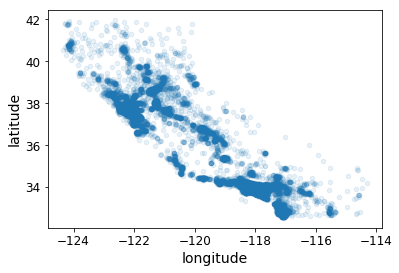

In [20]:
# PHASE 2: DATA EXPLORATION
# put test_set aside and explore train_set

housing = strat_train_set.copy()

#visualize training set
# alpha attribute helps see high-density areas
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=.1)


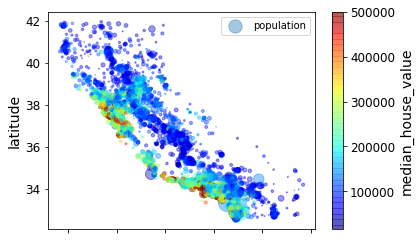

In [21]:
# option s/ size = population, option c/ color = price

housing.plot(kind="scatter", x='longitude',y='latitude', alpha=.4, 
            s=housing['population']/100, label='population',
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)

plt.legend()

In [22]:
# use clustering algorithm to detect main clusters and add new features that measure the proximity to the cluster centers. 

# MEASURING CORRELATIONS
# 1. compute pearson's correlation coefficient for every pair using corr(). 1 means perfect correlation
# however pearson's only see linear relationships and miss nonlinear ones
corr_matrix = housing.corr()

# how much does each attribute correlate with the median house value
corr_matrix['median_house_value'].sort_values(ascending=False)





median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ca71780>,
      dtype=object)

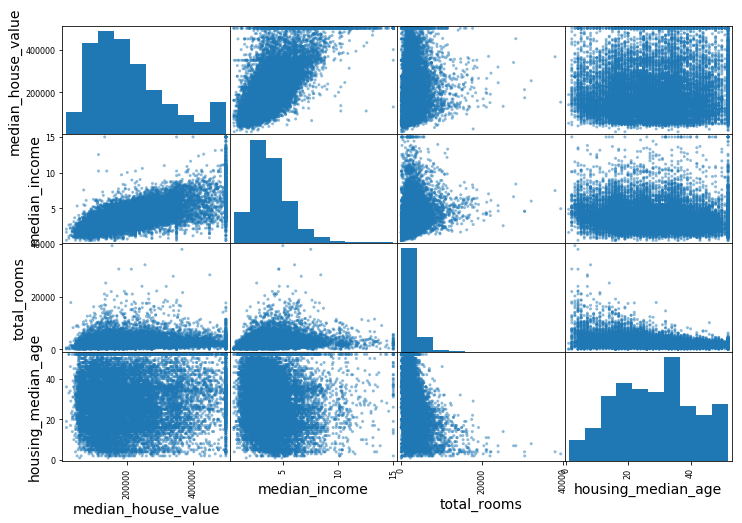

In [23]:
# 2. measuring correlation using scatter_matrix 

from pandas.tools.plotting import scatter_matrix

attributes = ['median_house_value','median_income','total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8))

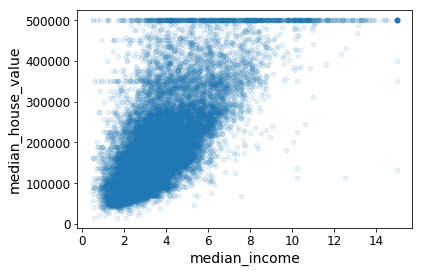

In [24]:
# zoom in to median income
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=.1)

# there are straight lines/ caps at 500k, 450k, 350. remove these so algorithm doesnt learn it

In [25]:
# try out various attribute combinations

housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

# rooms_per_household has higher correlation to house value compared to  total number of bedrooms


median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

# Step 4: Preparing/cleaning data for Machine Learning

In [26]:
# PHASE 3: PREPARE DATA FOR MACHINE LEARNING ALGORITHMS

# get a clean training data set again
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN,4.625369,0.223852,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN,6.008850,0.159057,2.707965
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN,4.225108,0.241291,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND,5.232295,0.200866,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN,4.505810,0.231341,3.047847


In [27]:
housing = strat_train_set.copy() 
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [28]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

1.a. fix missing data. total_bedrooms have missing values so clean it

In [29]:



# drop subset of rows that are blank
housing.dropna(subset=['total_bedrooms']).head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [30]:
# drop the entire total_bedrooms columns
housing.drop('total_bedrooms', axis=1).head()


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,4459.0,1463.0,3.0347,<1H OCEAN


In [31]:
# fill missing values with median value
# compute median manually 
# housing['total_bedrooms'].fillna(median)

# OR Scikit-learn's way of handling missing values with median:Imputer
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median')

# imputer requires all numerical columns so drop ocean_proximity

housing_num = housing.drop('ocean_proximity', axis=1)
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [32]:
# shows the computed median for each attribute that is stored in its .statistics_ instance
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [33]:
# check to see if values are same
housing_num.median().values
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [34]:
# use trained imputer to transform the training set by replacing missing values by the learned medians
X = imputer.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [35]:
# put array in dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Start processing categorical data

In [36]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Warning: earlier versions of the book used the LabelEncoder class or Pandas' Series.factorize() method to encode string categorical attributes as integers. However, the OrdinalEncoder class that is planned to be introduced in Scikit-Learn 0.20 (see PR #10521) is preferable since it is designed for input features (X instead of labels y) and it plays well with pipelines (introduced later in this notebook). For now, we will import it from future_encoders.py, but once it is available you can import it directly from sklearn.preprocessing.

In [37]:
# 1.b. Handling text and categorical attributes. Convert text labels to numbers
# use sckikit's transformer

# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# housing_cat = housing['ocean_proximity']
# # fit_transform means to fit it into data and make transformation. discussed in prev. pages
# housing_cat_encoded = encoder.fit_transform(housing_cat)
# housing_cat_encoded

In [38]:
# to know what these numbers mean
# print(encoder.classes_)


In [39]:
from future_encoders import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [40]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [41]:
# make text categories "comparable" or put value to them
# ML algorithms assume that two nearby values are similar (in a spectrum), 
# so use a binary attribute (0 for cold, 1 for hot) to represent this spectrum instead

from future_encoders import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [42]:
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [43]:
encoder.categories_

[array([0., 1., 2., 3., 4.])]

In [44]:
# instead of text cat --> integer cat --> one-hot vectors
from sklearn.preprocessing import LabelBinarizer 
encoder = LabelBinarizer(sparse_output=True) # numpy array by default. can be scipy by adding sparse_output = True
housing_car_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [45]:
# 1.c. custom transformers for custom uses

from sklearn.base import BaseEstimator, TransformerMixin

#column index
rooms_ix, bedrooms_ix, population_ix, household_ix=3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix]/X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix]/ X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)




# 1.d feature scaling. ensure that numerical atttributes have the same scales/ranges. Use min-max scaling or standardizaion


In [46]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [47]:
# !! can use transformation pipelines to execute data cleaning in right order
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# pipeline for numerical values
num_pipeline = Pipeline([('imputer', Imputer(strategy='median')),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler())
                         ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

# Step 4.a: Automate cleaning with a pipeline

First step of any pipeline is a DataFrameSelector

In [48]:
# make a custom function that selects a pandas dataframe using desired attributes
# or columns
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [49]:
# pipeline including categorical values using FeatureUnion - runs both numerical and categorical transformers' transform() method in parallel, waits output and concatenates them

from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

In [50]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [51]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [52]:
housing_prepared.shape

(16512, 16)

# Step 5: Select and train Machine Learning model. Model Validation

# 5.a Training. Will need to use test set for this

In [53]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

1. Train a linear regression on housing dataset

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Commands to do "activate" steps 1-4 and get to step 5. THIS IS JUST TESTING IF FUNCTIONS WORK.

In [55]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849878]


In [56]:
print("Labels:\t\t", list(some_labels))

Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Measure linear regressions' RMSE on on training set. 

In [57]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

Results say that there is a typical prediction error of $68628. Underfitting happened. 
How to improve?
1. select more powerful model
2. give better data
3. reduce constraints on model

THEN,
2. Try DecisionTreeRegressor. Finds complex nonlinear relationships in data

In [58]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Use trained model on training dataset

In [59]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_mse

0.0

# 5.b Validation stage

Having an RMSE of 0 might mean it is OVERFITTED. We cannot use test set until we're sure of our model. Still try a few more models for model validation or further evaluate DecisionTreeRegressor

To further evaluate, use Scikit-Learn's cross validation feature

In [60]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

What happened is K-fold cross validation, where training set is randomly split into 10 subsets/folds, and these folds gets trained and evaluated using DecisionTreeReegressor 10 times.

For every fold, one of 10 is evaluated/tested while 9 are use for training. 

In [61]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:",scores.mean())
    print("Standard Deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [69316.02634772 65498.84994772 71404.25935862 69098.46240168
 70580.30735263 75540.88413124 69717.93143674 70428.42648461
 75888.17618283 68976.12268448]
Mean: 70644.94463282847
Standard Deviation: 2938.9378926251234


With a mean of ~$70889 RMSE, it is worse than linear regression. 

# Go back to step 5.a because we tested the wrong model

Try 
2. RandomForestRegressor. It trains many decision trees on random subsets of features and averages their predictions

This step is considered a training set

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [63]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22252.73894310832

Overfitting still happens, but proceed 

# Step 5.b: Validation stage of the ForestRegressor

Will use validation sets

In [64]:
from sklearn.model_selection import cross_val_score

# only forest_reg changed in parameters
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, 
                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [65]:
display_scores(forest_rmse_scores)

Scores: [52869.23106834 49189.93801195 51726.73647871 54995.98190463
 50979.93079904 55978.43765914 52283.7609046  51001.92227546
 54447.35786983 53389.94422283]
Mean: 52686.32411945208
Standard Deviation: 1971.265477949874


With a mean of \$52656 it is better by \$20,000 compared to Decision Tree model. 

Analysis: score on training set is way smaller compared to that in validation set = data is OVERFITTING the training set (related to hyperparameters). 

i.e. Model performs way better in training stage than in validation stage

WHY?

Model finds data has too many parameters to play with so it plays with the wrong variables. 


$On$ $another$ $note,$ underfitting the training data means it needs more data to play with. 

Solutions:
1. Simplify model
2. COnstrain it
3. Get more training data

OR can aso try out other models and find 2-5 promising models

Once you found your models, start

# Step 6: Fine-tuning models

1. where you play with the hyperparameters using GRID SEARCH. Suitable only if there are a few combinations possible

Tell which hyperparameters it needs to play with, and parameters it will use
Output: all possible combinations of hyperparameter values using cross-validation

In [66]:
from sklearn.model_selection import GridSearchCV

param_grid = [ 
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap': [False], 'n_estimators':[3,10],'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Param grid tells Scikit-learn to: 
    1. evaluate all 3 x 4 = 12 combinations of n_estimators and max_features
    2. then try all 2 x 3 = 6 combinations of hyperparameters of hyperparameter values but with bootstrap = False
    
So sci-kit will 
    1. go through 18 combinations of RandomForestRegressor hyperparameter values 
    2. train each model five times (because we are using 5-fold cross validations)
Therefore, 18 x 5 = 90 rounds of training!

To get only the best parameters:

In [67]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [68]:
# or just the best estimator
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

To get all evaluation scores

In [69]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64583.23831343775 {'max_features': 2, 'n_estimators': 3}
55576.873722117016 {'max_features': 2, 'n_estimators': 10}
52956.30662941401 {'max_features': 2, 'n_estimators': 30}
60717.61577683773 {'max_features': 4, 'n_estimators': 3}
52634.105267438536 {'max_features': 4, 'n_estimators': 10}
50528.74511007911 {'max_features': 4, 'n_estimators': 30}
58493.21467912166 {'max_features': 6, 'n_estimators': 3}
52208.348666826736 {'max_features': 6, 'n_estimators': 10}
49924.88903176482 {'max_features': 6, 'n_estimators': 30}
58650.6191468369 {'max_features': 8, 'n_estimators': 3}
52369.18784516499 {'max_features': 8, 'n_estimators': 10}
50109.84568776333 {'max_features': 8, 'n_estimators': 30}
62470.342102357106 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54496.78629093729 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60353.800853111454 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52397.67552164831 {'bootstrap': False, 'max_features': 3, 'n_estimators'

The highest value / lowest RMSE is that with parameters max_features = 6, n_estimators = 30 at 49924.88

    2. Randomized search/ RandomizedSearchCV. Great when the hyperparameter search space is large.

Instead of looking at all combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. 

Great becayse it can explore many different values for each parameters and you wil have more control over allocation of memory in computing, by just setting number of iterations

     3. Ensemble methods. Combining models that perform best

# Step 7: Analyzing best models and their flaws

Example: RandomForestRegressor

Look at the attributes that contribute the most to its accuracy, and discard those that are not helping. Use ".feataure\_importances_" attribute

In [73]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.69687766e-02, 7.04319887e-02, 4.38660619e-02, 1.80630448e-02,
       1.66508742e-02, 1.79482850e-02, 1.59942989e-02, 3.27548930e-01,
       5.57736006e-02, 1.05319561e-01, 9.13965806e-02, 1.16638033e-02,
       1.38350194e-01, 1.03976446e-04, 3.83940095e-03, 6.08062375e-03])

To display values with their attribute names

In [75]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold","bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.32754893001195934, 'median_income'),
 (0.13835019350471953, 'INLAND'),
 (0.10531956070724346, 'pop_per_hhold'),
 (0.09139658055040592, 'bedrooms_per_room'),
 (0.07696877663966344, 'longitude'),
 (0.07043198869339834, 'latitude'),
 (0.05577360056115168, 'rooms_per_hhold'),
 (0.04386606192454317, 'housing_median_age'),
 (0.018063044805051474, 'total_rooms'),
 (0.01794828495917463, 'population'),
 (0.016650874220719983, 'total_bedrooms'),
 (0.01599429894210943, 'households'),
 (0.01166380333543238, '<1H OCEAN'),
 (0.006080623745976418, 'NEAR OCEAN'),
 (0.0038394009525752966, 'NEAR BAY'),
 (0.00010397644587548846, 'ISLAND')]

# Step 8: Evaluating System on the Test Set

Process: get predictors and labels from test set, run full_pipeline, and evaluate final model

Note:  we just use transform instead of transform_fit on full_pipeline, because we have already fit the data / centered the data on the model during the Training process. 

In [77]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

x_test_prepared = full_pipeline.transform(x_test)
final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47547.54607409892

# Step 9: Launch, Monitor, and Maintain your System

In [ ]:
Need to check system's live performance at regular intervals and trigger alerts when it drops. Models can rot as data evolves over time. Need to retrain using new data.

Evaluating system's performance will require sampling the sys's predictions and evaluating them. Will require human analysts, can be from Mechanical Turk or CrowdFlower

